In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

# --- 3-Way Split: Train (70%), Val (15%), Test (15%) ---
# First, split off the Test set (15%)
train_val_df, test_df = train_test_split(
    img_labels, 
    test_size=0.15, 
    stratify=img_labels['label'], 
    random_state=42
)

# Then, split the remaining 85% into Train (70% total) and Val (15% total)
# 0.15 / 0.85 = ~0.1765
val_size = 0.15 / 0.85
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=val_size, 
    stratify=train_val_df['label'], 
    random_state=42
)

print(f"Train set: {len(train_df)} images")
print(f"Val set:   {len(val_df)} images")
print(f"Test set:  {len(test_df)} images")

display(train_df.head())

training_data = GlobalStreetscapesSample(train_df)
validation_data = GlobalStreetscapesSample(val_df)
test_data = GlobalStreetscapesSample(test_df)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(validation_data, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200632
img_labels rows: 190690
Train set: 133482 images
Val set:   28604 images
Test set:  28604 images


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
35332,84ad10a6-f99d-4869-ab44-60cb25e2407b,Mapillary,485953953006702,Washington,United States,USA,9923602143506333696,27,38.901674,-77.021931,../data/imgs/d14ff11e-d0d7-4903-b5a0-791314cc5...
178610,8ceb2bac-1c95-496f-a880-8105582f58dd,Mapillary,330534595198853,Washington,United States,USA,9923602164444299264,22,38.895636,-77.028128,../data/imgs/6311a91a-5d74-424a-9e25-aa60e718e...
116704,739a5937-1756-4257-8795-17b6b1e62f8e,Mapillary,546316286932627,Washington,United States,USA,9923602129816125440,120,38.894806,-77.018920,../data/imgs/407bc03f-0b96-4c71-b46f-3fc578859...
116122,f8891d78-3dc7-42bd-bbae-b452ce05a49b,Mapillary,1040661636882612,Washington,United States,USA,9923602112904691712,55,38.903450,-77.015238,../data/imgs/407bc03f-0b96-4c71-b46f-3fc578859...
70997,e0594550-b51b-471d-b0b9-00bc2e413450,Mapillary,390664792252348,Washington,United States,USA,9923602134111092736,53,38.894814,-77.023504,../data/imgs/24dac46f-59d0-474d-bd5a-0b7657d5e...


Washington


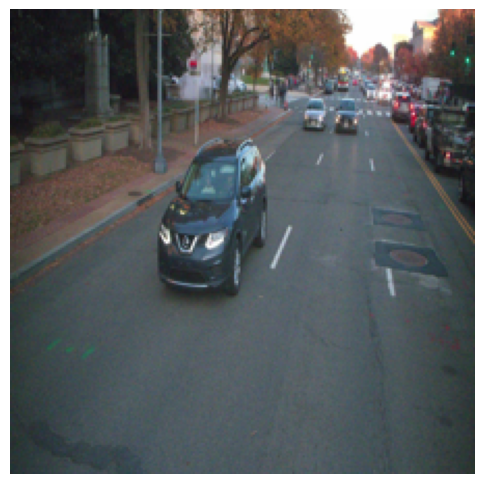

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# ConvNeXt Base Docs: https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_base.html
weights = ConvNeXt_Base_Weights.DEFAULT
transform = weights.transforms()

model = convnext_base(weights=weights)

# ConvNeXt classifier is a Sequential block. The last layer [2] is the Linear layer.
in_features = model.classifier[2].in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.classifier[2]}")
model.classifier[2] = torch.nn.Linear(in_features=in_features, out_features=num_classes)
print(f"New head: {model.classifier[2]}")
print(f"Number of classes: {num_classes}")

# Move to GPU with channels_last memory format for NVIDIA optimization
model = model.to(device=device, memory_format=torch.channels_last)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:04<00:00, 72.1MB/s] 


Previous head: Linear(in_features=1024, out_features=1000, bias=True)
New head: Linear(in_features=1024, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [6]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Initialize GradScaler for Automatic Mixed Precision (AMP)
# Updated to new torch.amp API
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    # --- Training Phase ---
    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader, desc="Training"):
        # Move to GPU with non_blocking and channels_last memory format
        inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting (FP16)
        with torch.amp.autocast('cuda'):
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
        
        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        scheduler.step() 
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        # Use val_dataloader here instead of test_dataloader
        for inputs, labels in tqdm(val_dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            
            # AMP for validation as well
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    torch.save(model.state_dict(), f'convnext_base_epoch{epoch}.pth')

EPOCH: 1


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 4.674 | Val Loss: 3.745
LR: 0.000052
EPOCH: 2


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 2.882 | Val Loss: 2.156
LR: 0.000100
EPOCH: 3


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.972 | Val Loss: 1.795
LR: 0.000099
EPOCH: 4


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.622 | Val Loss: 1.627
LR: 0.000097
EPOCH: 5


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.415 | Val Loss: 1.523
LR: 0.000093
EPOCH: 6


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.273 | Val Loss: 1.470
LR: 0.000088
EPOCH: 7


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.168 | Val Loss: 1.443
LR: 0.000082
EPOCH: 8


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.089 | Val Loss: 1.416
LR: 0.000075
EPOCH: 9


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 1.032 | Val Loss: 1.412
LR: 0.000067
EPOCH: 10


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.990 | Val Loss: 1.408
LR: 0.000059
EPOCH: 11


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.961 | Val Loss: 1.386
LR: 0.000050
EPOCH: 12


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.938 | Val Loss: 1.382
LR: 0.000041
EPOCH: 13


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.921 | Val Loss: 1.386
LR: 0.000033
EPOCH: 14


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.909 | Val Loss: 1.375
LR: 0.000025
EPOCH: 15


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.899 | Val Loss: 1.376
LR: 0.000018
EPOCH: 16


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.893 | Val Loss: 1.369
LR: 0.000012
EPOCH: 17


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.888 | Val Loss: 1.368
LR: 0.000007
EPOCH: 18


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.885 | Val Loss: 1.364
LR: 0.000003
EPOCH: 19


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.883 | Val Loss: 1.363
LR: 0.000001
EPOCH: 20


Training:   0%|          | 0/522 [00:00<?, ?it/s]

Validation:   0%|          | 0/112 [00:00<?, ?it/s]

Train Loss: 0.882 | Val Loss: 1.362
LR: 0.000000


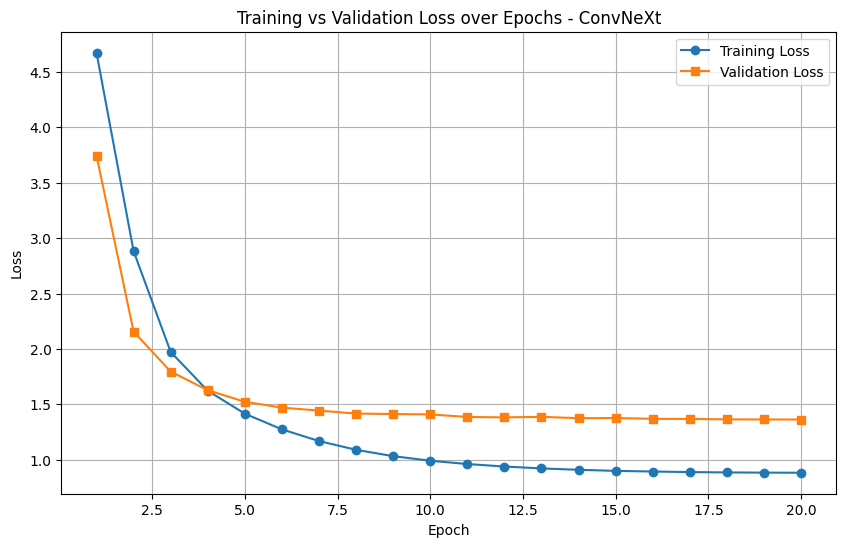

In [7]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs - ConvNeXt')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/112 [00:00<?, ?it/s]

Test Loss: 1.371
Test Accuracy: 84.60%
